In [24]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy

In [47]:
# Load datasets
train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)

In [48]:
# Convert authors, publisher, and language to numbers (in both training and testing set)
string_features = ['Authors', 'Publisher', 'Language']
for feature in string_features: 
    all_values = np.concatenate((train_df[feature], test_df[feature]))
    num, mapping = pd.factorize(all_values)
    numerical_feature_train = pd.Categorical(train_df[feature], mapping).codes
    numerical_feature_test = pd.Categorical(test_df[feature], mapping).codes
    train_df[feature] = numerical_feature_train
    test_df[feature] = numerical_feature_test

# Convert rating_label to categorical class label
train_df['rating_label'] = train_df['rating_label'].astype('category')
# print(train_df.dtypes)

In [57]:
x_full_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
x_full_test = test_df.iloc[:,:-1]

In [50]:
train_df  # with string attributes encoded to numerical

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
0,Best of Dr Jean: Reading & Writing,0,2005,6,1,0,-1,48,Teachers will turn to this treasury of ideas a...,4.0
1,Here All Dwell Free,1,1991,10,1,1,-1,364,Every human being lives a fairy tale -- an unc...,4.0
2,Boomer's Big Surprise,2,2005,3,31,2,-1,32,<i>Boomer's Big Surprise</i> will have special...,4.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",3,2004,9,1,3,-1,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0
4,Us,4,2005,7,7,4,0,352,"Since their days at Oxford, they've gone their...",3.0
...,...,...,...,...,...,...,...,...,...,...
23058,Black Coffee Blues,16300,1997,8,1,4245,0,120,"""If I lose the light of the sun, I will write ...",4.0
23059,America's Champion Swimmer: Gertrude Ederle,1250,2005,6,1,47,-1,32,"Trudy Ederle loved to swim, and she was determ...",4.0
23060,Crime and Custom in Savage Society,14077,1989,2,15,298,-1,132,Bronislaw Malinowski achieved international re...,4.0
23061,The Name and Nature of Poetry and Other Select...,8284,1998,4,21,4246,-1,136,Lovers of Housman's poetry and admirers of his...,4.0


In [51]:
# Save the numerical features as a matrix
numerical_train_matrix = x_full_train[['Authors', 'Publisher', 'Language']].to_numpy()
numerical_test_matrix = x_full_test[['Authors', 'Publisher', 'Language']].to_numpy()
np.savez_compressed('train_numerical.npz', numerical_train_matrix)
np.savez_compressed('test_numerical.npz', numerical_test_matrix)
# print(numerical_train_matrix)

[[    0     0    -1]
 [    1     1    -1]
 [    2     2    -1]
 ...
 [14077   298    -1]
 [ 8284  4246    -1]
 [10496    83    -1]]


# Data Visualisation

In [7]:
# Look at NMI of the numerical attributes

from sklearn.metrics.cluster import normalized_mutual_info_score

for feature in ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']:
    print(f"NMI for {feature} =", normalized_mutual_info_score(x_full_train[feature], y_train))

NMI for PublishYear = 0.005010413368619569
NMI for PublishMonth = 0.0007191125502055215
NMI for PublishDay = 0.0013529681241697595
NMI for pagesNumber = 0.01964529722439041


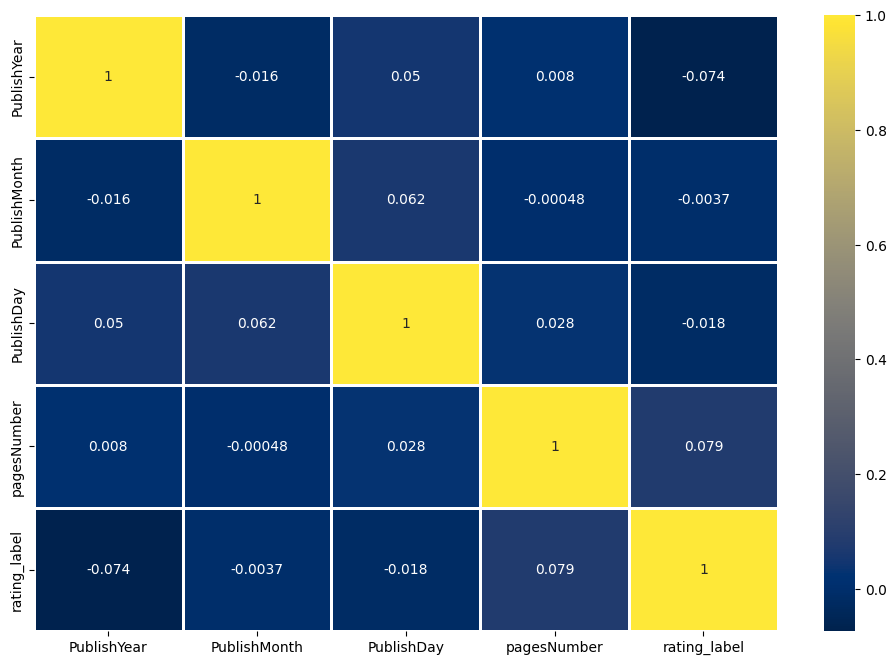

In [8]:
# Look at the correlation matrix of the numerical attributes

cor_matrix = train_df[['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber', 'rating_label']].corr()
round(cor_matrix,2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

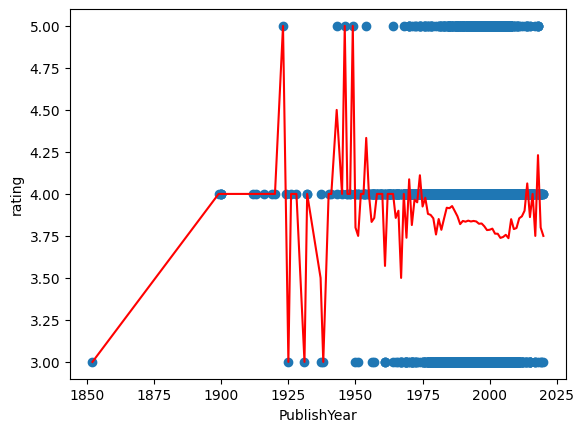

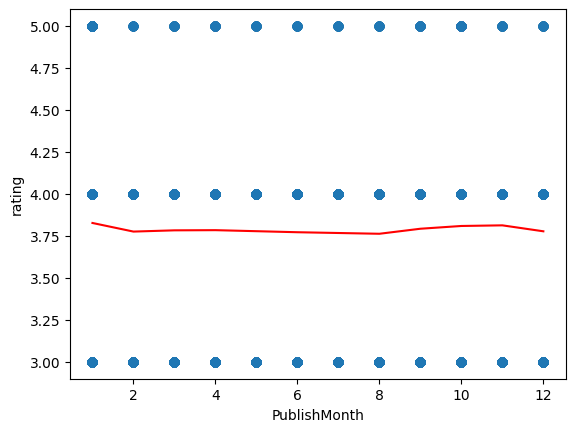

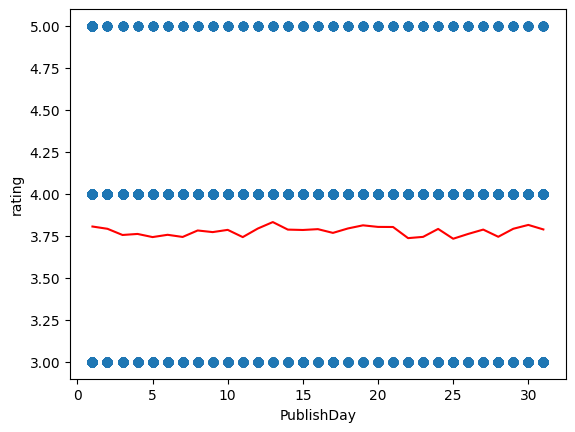

In [9]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay']: 
    plt.scatter(train_df[feature], train_df['rating_label'])
    plt.xlabel(feature)
    plt.ylabel('rating')

    values, counts = np.unique(sorted(train_df[feature]), return_counts=True)
    avg = []
    for i in range(len(values)): 
        v = values[i]
        c = counts[i]
        avg.append(sum(train_df.loc[train_df[feature] == v]['rating_label'])/c)
    plt.plot(values, avg, color = 'red')
    plt.show()

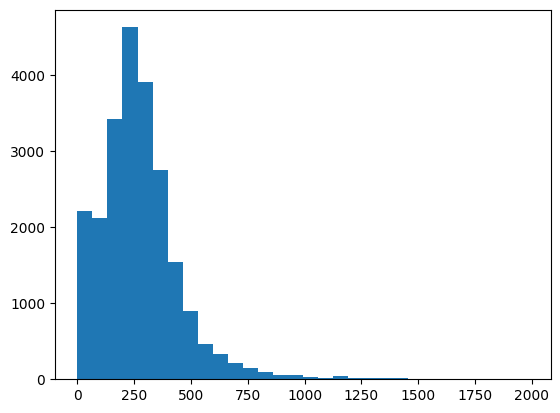

In [10]:
# Histogram for pages number < 2000
pageNum = train_df.loc[train_df['pagesNumber']< 2000]['pagesNumber']
plt.hist(pageNum, bins = 30)
plt.show()

# Feature Pre-processing

## M1: CountVectorizer

In [35]:
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [36]:
def tokenize(text):
    text = ''.join([c for c in text if c not in string.punctuation])  # punctuation removal
    tokens = nltk.word_tokenize(text)  # tokenization
    stop_words = set(stopwords.words('english'))
    no_stopwords = [w for w in tokens if w not in stop_words and len(w) > 2]  # stop words removal
    lemmatized = [WordNetLemmatizer().lemmatize(w) for w in no_stopwords]  # lemmatization
    return lemmatized

In [37]:
def preprocess_with_count_vectorizer(feature, train_df, test_df):
    train_corpus = train_df[feature]
    test = test_df[feature]
    
    vocab = CountVectorizer(tokenizer=tokenize).fit(train_corpus)
    x_train = vocab.transform(train_corpus)
    x_test = vocab.transform(test)
    
    scipy.sparse.save_npz(f'train_{feature}_countVectorizer.npz', x_train)
    scipy.sparse.save_npz(f'test_{feature}_countVectorizer.npz', x_test)
    
    return x_train, x_test

In [38]:
preprocess_with_count_vectorizer('Name', train_df, test_df)

(<23063x19678 sparse matrix of type '<class 'numpy.int64'>'
 	with 99140 stored elements in Compressed Sparse Row format>,
 <5766x19678 sparse matrix of type '<class 'numpy.int64'>'
 	with 21940 stored elements in Compressed Sparse Row format>)

In [ ]:
#vocab = pickle.load(open("/kaggle/input/book-text-features/book_text_features_countvec/train_name_countvectorizer.pkl", "rb"))

In [ ]:
#vocab_dict = vocab.vocabulary_

## M2: doc2Vec

In [15]:
import gensim
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [16]:
# size of the output vector
vec_size = 100

# function to preprocess and tokenize text
def tokenize_corpus(txt, tokens_only=False):
    for i, line in enumerate(txt):
        tokens = gensim.utils.simple_preprocess(line)
        tokens = [w for w in tokens if w not in stopwords.words('english') and len(w) > 2]  # stop words removal (also remove words too short)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]  # lemmatize
        #print(tokens)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [41]:
def preprocess_with_doc2vec(feature, train_df, test_df):
    train_corpus = train_df[feature]
    test = test_df[feature]
    # tokenize a training corpus
    corpus = list(tokenize_corpus(train_corpus))
    
    # train doc2vec on the training corpus
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vec_size, min_count=2, epochs=40)
    model.build_vocab(corpus)
    model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

    # tokenize new documents
    doc = list(tokenize_corpus(test, tokens_only=True))
    
    # generate embeddings for the new documents in training set
    x_train = np.zeros((len(doc),vec_size))
    for i in range(len(doc)):
        x_train[i,:] = model.infer_vector(doc[i])

    # generate embeddings for the new documents in test set
    x_test = np.zeros((len(doc),vec_size))  # type = numpy.ndarray
    for i in range(len(doc)):
        x_test[i,:] = model.infer_vector(doc[i])

    # print(x_test)
    # check the shape of doc_emb
    # print(x_test.shape)
    np.savetxt(f'train_{feature}_doc2vec.csv', x_train, delimiter=',')
    np.savetxt(f'test_{feature}_doc2vec.csv', x_test, delimiter=',')
    return x_train, x_test

In [42]:
preprocess_with_doc2vec('Name', train_df, test_df)

<class 'numpy.ndarray'>


(array([[ 0.11196963,  0.15273769,  0.04297854, ..., -0.04687104,
          0.01627849, -0.01782078],
        [ 0.08887995,  0.12251815,  0.076112  , ...,  0.05717133,
          0.12689632,  0.03760827],
        [-0.00845319, -0.07502079,  0.1706717 , ..., -0.04990534,
         -0.00581718, -0.0416918 ],
        ...,
        [-0.14250603,  0.12224836,  0.12557665, ..., -0.11931561,
          0.11730058,  0.13045765],
        [-0.14543054,  0.09632152, -0.03490108, ..., -0.0760228 ,
          0.14981148, -0.10012434],
        [ 0.05652768,  0.1308983 ,  0.03039257, ..., -0.09998382,
         -0.08211842,  0.01058627]]),
 array([[ 0.12027495,  0.17154205,  0.03829053, ..., -0.06923746,
          0.03413263, -0.03391378],
        [ 0.08102742,  0.12855253,  0.05120888, ...,  0.05298989,
          0.11989763,  0.03238111],
        [-0.02143106, -0.07820677,  0.16679144, ..., -0.05808017,
         -0.0561824 , -0.05156116],
        ...,
        [-0.11859014,  0.1144022 ,  0.14576271, ..., -

## M3: TfidfVectorizer

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
def preprocess_with_tfidf_vectorizer(feature, train_df, test_df):
    train_corpus = train_df[feature]
    test = test_df[feature]
    
    vocab = tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize).fit(train_corpus)
    x_train = vocab.transform(train_corpus)
    x_test = vocab.transform(test)
    
    scipy.sparse.save_npz(f'train_{feature}_tfidf.npz', x_train)
    scipy.sparse.save_npz(f'test_{feature}_tfidf.npz', x_test)
    
    return x_train, x_test

In [40]:
preprocess_with_tfidf_vectorizer('Name', train_df, test_df)

(<23063x19678 sparse matrix of type '<class 'numpy.float64'>'
 	with 99140 stored elements in Compressed Sparse Row format>,
 <5766x19678 sparse matrix of type '<class 'numpy.float64'>'
 	with 21940 stored elements in Compressed Sparse Row format>)

# Training

train_df: original training set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes
test_df: original test set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes
x_full_train: attributes in train_df
y_train: class labels (rankings) in train_df
x_full_test: attributes in test_df
y_test: class labels (rankings) in test_df
x_train_transformed:

In [52]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from scipy import sparse

In [53]:
# read in and combine the description & name tfidf matrices
description_tfidf_matrix = sparse.load_npz('train_Description_tfidf.npz')
name_tfidf_matrix = sparse.load_npz('train_Name_tfidf.npz')
text_matrix = sparse.hstack((description_tfidf_matrix, name_tfidf_matrix))
text_matrix

<23063x150210 sparse matrix of type '<class 'numpy.float64'>'
	with 1507259 stored elements in Compressed Sparse Row format>

In [54]:
# Extract the now numerical features as a matrix
numerical_matrix = np.load('train_numerical.npz')['arr_0']
#print(numerical_matrix.files)

# Combine with the text feature vectors to form a new matrix
X_train = sparse.hstack((sparse.csr_matrix(numerical_matrix), text_matrix))
X_train

<23063x150213 sparse matrix of type '<class 'numpy.float64'>'
	with 1570990 stored elements in Compressed Sparse Row format>

## Evaluation

In [55]:
# scoring for cross validation
def report_scoring(clf, X, y): 
    y_pred = clf.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    report_dict = {}
    for label in ['3.0', '4.0', '5.0']: 
        for metric in ['precision', 'recall', 'f1-score']: 
            report_dict[label + '_' + metric] = report[label][metric]
    report_dict['accuracy'] = report['accuracy']
    return report_dict

## SVM

In [56]:
from sklearn import svm

In [ ]:
# run SVM with description + name
linearSVM = sklearn.svm.LinearSVC(random_state = 30027)
result = cross_validate(linearSVM, X_train, y_train, scoring = report_scoring, cv=20)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [ ]:
# result of SVM with description + name
pd.DataFrame.from_dict(result)[['test_3.0_f1-score','test_4.0_f1-score','test_5.0_f1-score','test_accuracy']]

## Baseline - 0R & 1R

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [ ]:
# build and test 0R and 1R model
zero_r = DummyClassifier(strategy = 'most_frequent')
one_r = DecisionTreeClassifier(max_depth=1)
models = [zero_r, one_r]
X_train_num = X_ttrain
del X_train_num["Description"]
del X_train_num["Name"]
X_val_num = X_val
del X_val_num["Description"]
del X_val_num["Name"]
for model in models: 
    model.fit(X_train_num, y_ttrain)
    print(model)
    print(classification_report(y_val, model.predict(X_val_num)))
    print('\n\n')

## 

# Evaluation